Описание есть стартап который работает в сфере продуктов питания. Цель проекта узнать как пользователи доходят до покупки и проанализировать эксперимет компании по внедрению нового шрифта на странице сайта.

Для работы дан датасет где в котором по каждому пользователю проведённому по сайту собрано (его индентификатор, совершённые пользователем события, время эксперимента, номер группы (в зависимости на какой версии сайта находился участник))

## Импорт библиотек (загрузка данных)

In [1]:
!pip install plotly 

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
from datetime import datetime
import math as mth
from scipy import stats as st

In [3]:
lg = pd.read_csv('logs_exp.csv', sep='\t')

In [4]:
lg.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Подготовка данных

In [5]:
lg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
lg.columns = ['event', 'id', 'datetime', 'group']

In [7]:
lg.columns

Index(['event', 'id', 'datetime', 'group'], dtype='object')

In [8]:
lg['datetime'] = pd.to_datetime(lg['datetime'], unit='s')

In [9]:
lg.datetime.head()

0   2019-07-25 04:43:36
1   2019-07-25 11:11:42
2   2019-07-25 11:28:47
3   2019-07-25 11:28:47
4   2019-07-25 11:48:42
Name: datetime, dtype: datetime64[ns]

In [10]:
lg[lg.duplicated()].head()

,event,id,datetime,group
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248


In [11]:
lg.duplicated().sum()

413

In [12]:
lg = lg.drop_duplicates()
lg.duplicated().sum()

0

In [13]:
lg['date'] = lg['datetime'].dt.date
lg['time'] = lg['datetime'].dt.time
lg['date'] = pd.to_datetime(lg['date'])
lg.head()

,event,id,datetime,group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


При первичной подготовке данных выявлено:
1. Отсутсвие некорректных значений (NAN)
2. Присутсвие дубликатов (удалены)
3. Добавьте столбец даты и времени, а также отдельный столбец дат 

## Изучение и проверка данных

Проверим сколько всего событий в логе

In [14]:
display(lg.event.unique())
display(len(lg.event.unique()))

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

5

Проверим сколько всего пользователей в логе

In [15]:
display(len(lg.id.unique()))

7551

Проверим сколько в среднем событий приходится на пользователя

In [16]:
lg.pivot_table(index='id', values='event', aggfunc='nunique').event.mean()

2.6744802012978415

In [17]:
len(lg) / lg.id.nunique()

32.27559263673685

Посмотрим за какой период дат мы распологаем



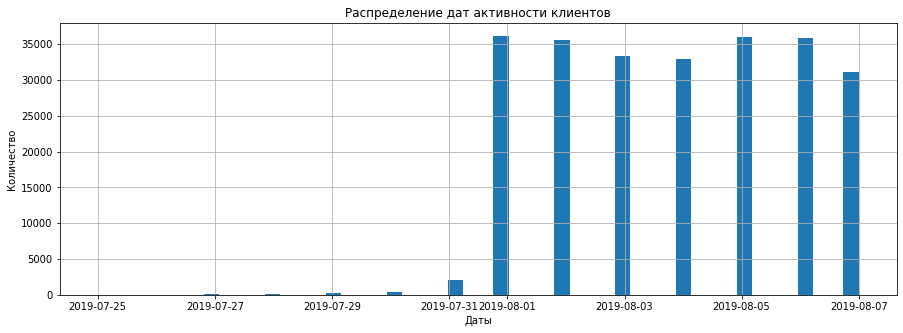

In [18]:
plt.figure(figsize=(15,5))
plt.title('Распределение дат активности клиентов')
plt.xlabel('Даты')
plt.ylabel('Количество')
lg.date.hist(bins=50)
plt.show()

Как видно на графике мы видим, что активный период наблюдений начался с 2019.08.01 . До это наблюдений крайне мало

Отбросим старые малочисленные даты, наблюдений в которых мало. Проверим на сколько это повлияет на количество всех данных

In [19]:
print(len(lg))
old = lg
lg = lg.query('date >= "2019-08-01"')
print(len(lg))

243713
240887


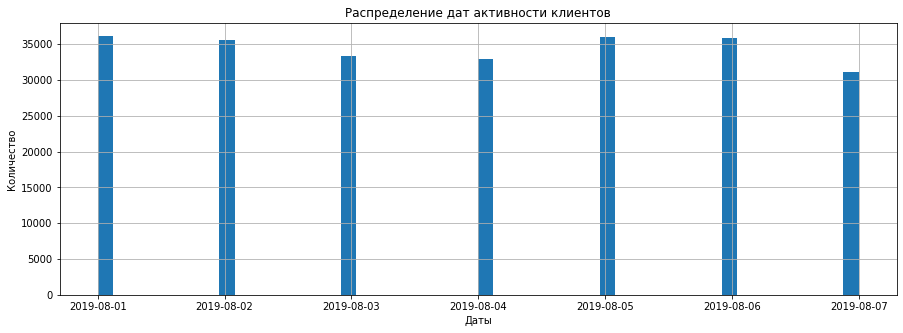

In [20]:
plt.figure(figsize=(15,5))
plt.title('Распределение дат активности клиентов')
plt.xlabel('Даты')
plt.ylabel('Количество')
lg.date.hist(bins=50)
plt.show()

Распределение дат теперь выглядит корректно, потерю данных можно назвать несущественной

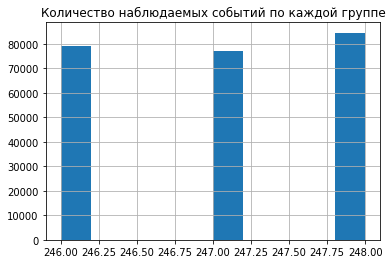

In [21]:
lg.group.hist()
plt.title('Количество наблюдаемых событий по каждой группе')
plt.show()

Пользователи по каждой группе сохранились в достаточном (почти в равном) количестве

Посчитаем изменение в пользователях

In [22]:
print('Абсолютное изменение в пользователях')
display(old.id.nunique() / lg.id.nunique())


print('Относительное изменение в пользователях')
display((old.id.nunique() - lg.id.nunique()) /  old.id.nunique())

print('Абсолютное изменение в событиях')
display(len(old) / len(lg))


print('Относительное изменение в собятиях')
display((len(old) - len(lg)) /  len(old))

Абсолютное изменение в пользователях


1.0022564374834086

Относительное изменение в пользователях


0.0022513574361011784

Абсолютное изменение в событиях


1.0117316418071545

Относительное изменение в собятиях


0.011595606307418972

In [23]:
first = old.groupby('event').agg({'id': 'nunique', 'group': 'count'}).reset_index()
second = lg.groupby('event').agg({'id': 'nunique', 'group': 'count'}).reset_index()
third = first.merge(second, on='event')
third['absolut_change_uniq_users'] = third.id_x / third.id_y
third['relative_change_uniq_users'] = (third.id_x - third.id_y) / third.id_x
third['absolut_change_all_events'] = third.group_x / third.group_y
third['relative_change_all_events'] = (third.group_x - third.group_y) / third.group_x
display(third[['event','absolut_change_uniq_users','relative_change_uniq_users','absolut_change_all_events','relative_change_all_events']])

,event,absolut_change_uniq_users,relative_change_uniq_users,absolut_change_all_events,relative_change_all_events
0,CartScreenAppear,1.004017,0.004001,1.008628,0.008554
1,MainScreenAppear,1.002696,0.002689,1.015111,0.014887
2,OffersScreenAppear,1.004354,0.004336,1.010252,0.010148
3,PaymentScreenSuccessful,1.002261,0.002255,1.005897,0.005862
4,Tutorial,1.008333,0.008264,1.012935,0.012770


## Изучим воронку событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

,event,id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


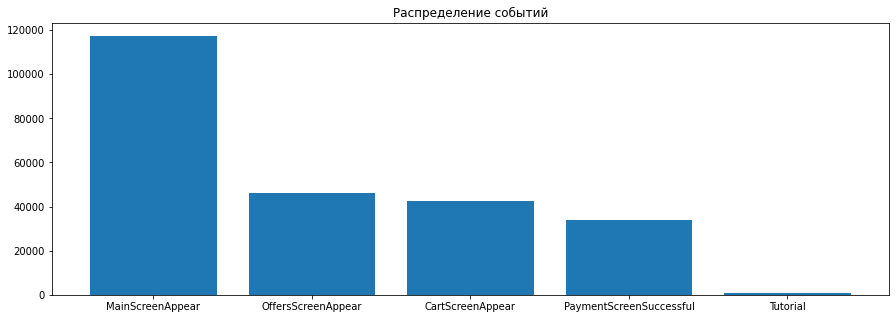

In [24]:
event_count = lg.pivot_table(index='event', values='id', aggfunc='count').sort_values(by='id', ascending=False).reset_index()
display(event_count)
plt.figure(figsize=(15,5))
plt.title('Распределение событий')
plt.bar(event_count.event, event_count.id)
plt.show()

Большинство количество событий MainScreenAppear (показ главного экрана), котороый сильно опережает все остальные, самый низкий показатель у события Tutorial, который намного ниже остальных

Мы так же видим что порядок у событий следующий:
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful
5. Tutorial

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие

In [25]:
event_idcount = lg.groupby('event', as_index=False).agg({'id' : 'nunique'}).sort_values(by='id',ascending=False)
# event_idcount['']
event_idcount['percent'] = list(map(lambda x: f'{x:.2f}', (event_idcount.id/lg.id.nunique())*100))
event_idcount

,event,id,percent
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


In [26]:
only_event = lg.pivot_table(index='id', values='event', aggfunc='nunique').reset_index()\
.pivot_table(index='event', values='id', aggfunc='count').reset_index()
only_event['percent'] = list(map(lambda x: float(f'{x:.2f}'), (only_event.id/only_event.id.sum())*100))
only_event.columns = ['Событие', 'Пользователи', 'Процент']
only_event['Событие'] = only_event['Событие'] - 1
only_event['Событие'] = only_event['Событие'].map(dict(map(lambda x: list(x) , enumerate(event_count.event))))
only_event

,Событие,Пользователи,Процент
0,MainScreenAppear,2717,36.06
1,OffersScreenAppear,1004,13.33
2,CartScreenAppear,318,4.22
3,PaymentScreenSuccessful,3029,40.20
4,Tutorial,466,6.19


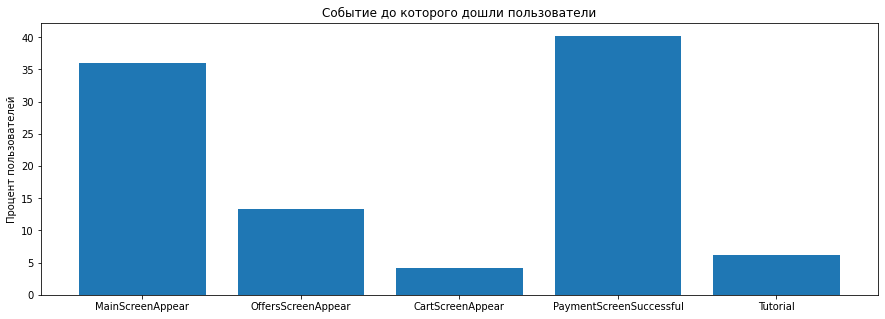

In [27]:
plt.figure(figsize=(15,5))
plt.title('Событие до которого дошли пользователи')
plt.ylabel('Процент пользователей')
plt.bar(only_event['Событие'], only_event['Процент'])
plt.show()

Как мы видим на средних этапах OffersScreenAppear и CartScreenAppear зависает малое количество пользователей, большинство пользователей остаётся на этапе MainScreenAppear и PaymentScreenSuccessful (не продвигаясь дальше). До последнего события дошло только 6% пользователе, хотя ещё на предыдущем событиии было 40%.

Посчитаем, какая доля пользователей проходит на следующий шаг воронки

In [28]:
lost = list()
list_users = list(event_idcount.id)

for x in range(len(list_users)):
    if x == 0:
        lost.append(0)
    else:
        lost.append(float(f'{(list_users[x]/list_users[x-1])*100:.2f}'))
event_idcount['switch'] = lost
event_idcount

,event,id,percent,switch
1,MainScreenAppear,7419,98.47,0.00
2,OffersScreenAppear,4593,60.96,61.91
0,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78
4,Tutorial,840,11.15,23.74


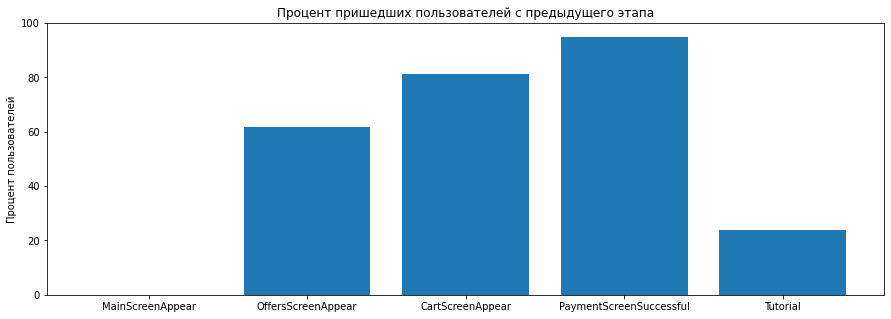

In [29]:
plt.figure(figsize=(15,5))
plt.ylim(0,100)
plt.title('Процент пришедших пользователей с предыдущего этапа')
plt.ylabel('Процент пользователей')
plt.bar(event_idcount['event'], event_idcount['switch'])
plt.show()

Как мы ещё раз убедились, большинство пользователей теряется на этапе Tutorial и на этапе OffersScreenAppear

Помсмотрим какая доля пользователей доходит с первого этапа до оплаты

In [30]:
(event_idcount.query('event == "PaymentScreenSuccessful"')['id'].values / event_idcount.query('event == "MainScreenAppear"')['id'].values)[0]

0.47701846610055265

Почти 48 процентов пользователей, с момента открытия первой страницы доходят до оплаты заказа

## Изучите результаты эксперимента

Посмотрим сколько пользователей в каждой экспериментальной группе

In [31]:
lg.groupby('group').agg({'id':'nunique'})

,id
group,
246,2484
247,2513
248,2537


В группах примерно равное количество участников, около 2500 в каждой

Самое важное событие будем считать покупку, для начала проведём А/А тест по каждому событию.За нулевую теорию примем то что наши группы одинаковы, за альтернативную, то что группы различны.

In [32]:
id_246 = set(lg.query('group == 246').id.unique())
id_247 = set(lg.query('group == 247').id.unique())
id_248 = set(lg.query('group == 248').id.unique())
print(len(id_246&id_247))
print(len(id_246&id_248))
print(len(id_247&id_248))

0
0
0


Как видим у нас отсутсвуют пользователи которые состоят больше чем в 1-ой группе

In [33]:
len(id_246 & set(lg.id.unique()))

2484

In [34]:
events = event_count.event.unique()

In [35]:
event_table = lg.pivot_table(index='group', columns='event', values='id', aggfunc='nunique')

aa = dict() # Сделаем ещё одну группу которая будет суммой из группы 246 и 247, назовём её группу 249
for x in range(5):
    f = event_table.loc[246, event_table.columns[x]]
    s = event_table.loc[247, event_table.columns[x]]
    aa[event_table.columns[x]] = s + f
event_table = event_table.append(aa, ignore_index=True)
event_table.index = (list(range(246,250)))
event_table

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
246,1266,2450,1542,1200,278
247,1238,2476,1520,1158,283
248,1230,2493,1531,1181,279
249,2504,4926,3062,2358,561


In [36]:
# Создадим таблицу уникальных пользователей в группе
uniq_group = lg.pivot_table(index='group', values='id', aggfunc='nunique')
aa = dict() # Сделаем ещё одну группу которая будет суммой из группы 246 и 247, назовём её группу 249
f = uniq_group.loc[246, 'id']
s = uniq_group.loc[247, 'id']
aa[uniq_group.columns[0]] = s + f
uniq_group = uniq_group.append(aa, ignore_index=True)
uniq_group.index = (list(range(246,250)))
uniq_group

,id
246,2484
247,2513
248,2537
249,4997


In [37]:
def z_test(group_1, group_2, event):
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([event_table.loc[group_1, event], event_table.loc[group_2, event]])
    trials = np.array([uniq_group.loc[group_1, 'id'], uniq_group.loc[group_2, 'id']])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

In [38]:
z_test(246, 247, 'MainScreenAppear')

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
for x in range(len(events)):
    print(f'Тест между группами 246 и 247 по событию {events[x]}')
    z_test(246,247, events[x])
    print('---------------------------------------------------')


Тест между группами 246 и 247 по событию MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 246 и 247 по событию OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 246 и 247 по событию CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 246 и 247 по событию PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 246 и 247 по событию Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть ну

По результатам А/А анализа, выяснилось, что все группы 246 и 247 не имеют статистически различных значений по всем 4 событиям

Проведём теперь А/B анализ между группами

In [40]:
for x in range(len(events)):
    print(f'Тест между группами 246 и 248 по событию {events[x]}')
    z_test(246,248, events[x])
    print('---------------------------------------------------')


Тест между группами 246 и 248 по событию MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 246 и 248 по событию OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 246 и 248 по событию CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 246 и 248 по событию PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 246 и 248 по событию Tutorial
p-значение:  0.8264294010087645
Не получилось отвергнуть ну

In [41]:
for x in range(len(events)):
    print(f'Тест между группами 247 и 248 по событию {events[x]}')
    z_test(247,248, events[x])
    print('---------------------------------------------------')


Тест между группами 247 и 248 по событию MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 247 и 248 по событию OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 247 и 248 по событию CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 247 и 248 по событию PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 247 и 248 по событию Tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулев

In [42]:
for x in range(len(events)):
    print(f'Тест между группами 249 и 248 по событию {events[x]}')
    z_test(249,248, events[x])
    print('---------------------------------------------------')


Тест между группами 249 и 248 по событию MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 249 и 248 по событию OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 249 и 248 по событию CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 249 и 248 по событию PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------
Тест между группами 249 и 248 по событию Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть ну

По результатам A/B анализа во всех трёх случаях мы получили разницу между событиями 'MainScreenAppear', 'OffersScreenAppear'. В двух случаях получили разницу между событиями 'CartScreenAppear', 'PaymentScreenSuccessful' (но в этих двух случаях p value близко к пяти процентам).
В итоге стоит признать признать можно отвергнуть только теорию о равенстве по событиям 'MainScreenAppear', 'OffersScreenAppear'

Рассмотрим в положительную сторону ли произошли изменения

А/В тест не смог опровергнуть нулевую теорию, между группами нет статистической разницы в значених

## Вывод

1. При первичной подготовке данных выявлено:
Отсутсвие некорректных значений (NAN)
Присутсвие дубликатов (удалены)
Добавьте столбец даты и времени, а также отдельный столбец дат
2. Активный период наблюдений начался с 2019.08.01 . До это наблюдений крайне мал
3. Большинство количество событий MainScreenAppear (показ главного экрана), котороый сильно опережает все остальные, самый низкий показатель у события Tutorial, который намного ниже остальных Мы так же видим что порядок у событий следующий:
MainScreenAppear
OffersScreenAppear
CartScreenAppear
PaymentScreenSuccessful
Tutorial
4. На средних этапах OffersScreenAppear и CartScreenAppear зависает малое количество пользователей, большинство пользователей остаётся на этапе MainScreenAppear и PaymentScreenSuccessful (не продвигаясь дальше). До последнего события дошло только 6% пользователе, хотя ещё на предыдущем событиии было 40%.
5. Почти 48 процентов пользователей, с момента открытия первой страницы доходят до оплаты заказа
6. Исходя из А/А анализа мы видим, что статистической значимой разницы между значениями не
7. По результатам A/B мы не получили разницу между группами, группы индентичны
